Following [a simple but efficient real-time voice activity detection algorithm](https://www.eurasip.org/Proceedings/Eusipco/Eusipco2009/contents/papers/1569192958.pdf)

In [405]:
import torch
import torchaudio
import matplotlib.pyplot as plt

In [406]:
yn = torchaudio.datasets.YESNO("~/yesno")

waveform = yn[0][0]
sample_rate = 8 * 10**3

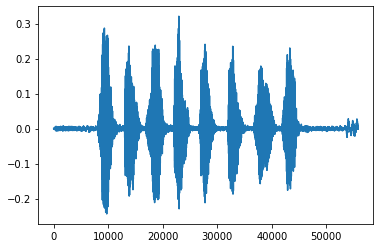

In [407]:
waveform = waveform[0,:].view(1,-1)

plt.figure()
plt.plot(waveform.transpose(0,1).numpy())

In [408]:
torchaudio.legacy.save("sound.wav", waveform.t(), sample_rate)

import IPython.display as ipd
ipd.Audio("sound.wav")

n = 20
frame_fft = torch.rfft(frame, 1)
amplitudes = torchaudio.functional.complex_norm(frame_fft)
    
frequency = amplitudes.argmax()
spectral_flatness = compute_spectral_flatness(amplitudes)

In [409]:
torchaudio.legacy.save("yesno.wav", waveform.t(), sample_rate)

In [410]:
EPSILON = 0.01

In [411]:
frame.nonzero().size()

torch.Size([80, 2])

In [412]:
def compute_spectral_flatness(frame):
    n = frame.nonzero().size(0)
    # geometric_mean = torch.exp((EPSILON + frame).log().sum(-1)/n) - EPSILON
    # arithmetic_mean = frame.sum(-1)/n
    # geometric_mean = 0 if not (frame == 0).nonzero().size()[0] else torch.exp(frame.log().mean(-1))
    geometric_mean = torch.exp((EPSILON + frame).log().mean(-1)) - EPSILON
    # length = frame.size(-1)
    # geometric_mean = frame.prod(-1).pow(1/length)
    arithmetic_mean = frame.mean(-1)
    # print(frame)
    # print(frame.log())
    # print(geometric_mean, arithmetic_mean)
    # return 10 * torch.log10(EPSILON + geometric_mean/arithmetic_mean)
    return - 10 * torch.log10(EPSILON + geometric_mean/arithmetic_mean)
    # return geometric_mean/arithmetic_mean

def compute_short_term_energy(frame):
    return frame.pow(2).sum(-1)

In [413]:
import math

waveform_length = waveform.size()[-1]

frame_time = 10**-2  # 10 ms
frame_size = int(math.ceil(sample_rate*frame_time))
num_of_frames = math.floor(waveform_length/frame_size)

num_init_frames = 30
ignore_silent_count = 10
ignore_speech_count = 5

energy_prim_thresh = 40
frequency_prim_thresh = 5
spectral_flatness_prim_thresh = 3

speech_frames = []
silent_count = 0

energy_list = []
frequency_list = []
spectral_flatness_list = []

for n in range(num_of_frames):
    frame = waveform[0, n*frame_size:(n+1)*frame_size].view(1,-1)
    
    energy = compute_short_term_energy(frame)
    
    # frame_stft = torch.stft(frame, frame_size, hop_length=frame_size, win_length=frame_size)
    frame_fft = torch.rfft(frame, 1)
    amplitudes = torchaudio.functional.complex_norm(frame_fft)
    
    frequency = amplitudes.argmax()
    spectral_flatness = compute_spectral_flatness(amplitudes)

    energy_list.append(energy)
    frequency_list.append(frequency)
    spectral_flatness_list.append(spectral_flatness)
    
    if n == 0:
        min_energy = energy
        min_frequency = frequency
        min_spectral_flatness = spectral_flatness
        # continue
    elif n < num_init_frames:
        min_energy = min(energy, min_energy)
        min_frequency = min(frequency, min_frequency)
        min_spectral_flatness = min(spectral_flatness, min_spectral_flatness)
        # print(min_frequency)
        # print(min_spectral_flatness)
        # continue
    
    thresh_energy = energy_prim_thresh * torch.log(EPSILON + min_energy)
    thresh_frequency = frequency_prim_thresh
    thresh_spectral_flatness = spectral_flatness_prim_thresh
    
    counter = 0

    if energy - min_energy >= thresh_energy:
        print(n, "energy", energy, min_energy, energy-min_energy, thresh_energy)
        counter += 1
    if frequency - min_frequency >= thresh_frequency: 
        print(n, "freq", frequency, min_frequency, frequency-min_frequency, thresh_frequency)
        counter += 1
    if spectral_flatness - min_spectral_flatness >= thresh_spectral_flatness: 
        print(n, "sf", spectral_flatness, min_spectral_flatness, spectral_flatness - min_spectral_flatness, thresh_spectral_flatness)
        counter += 1
    
    if counter > 1:
        # Detected: Speech
        speech_frames.append(True)
        silent_count = 0
    else:
        # Detected: Silent
        speech_frames.append(False)
        min_energy = ((silent_count * min_energy) + energy) / (silent_count + 1)
        thresh_energy = energy_prim_thresh * torch.log(EPSILON + min_energy)
        silent_count += 1

# count_dups = count_consecutive_duplicate(speech_frames)
# print(count_dups)


0 energy tensor([1.4296e-06]) tensor([1.4296e-06]) tensor([0.]) tensor([-184.2011])
1 energy tensor([7.7548e-05]) tensor([1.4296e-06]) tensor([7.6119e-05]) tensor([-184.2011])
2 energy tensor([0.0001]) tensor([3.9489e-05]) tensor([6.6187e-05]) tensor([-184.0492])
3 energy tensor([0.0003]) tensor([6.1551e-05]) tensor([0.0003]) tensor([-183.9613])
4 energy tensor([0.0010]) tensor([0.0001]) tensor([0.0009]) tensor([-183.7044])
5 energy tensor([0.0009]) tensor([0.0003]) tensor([0.0006]) tensor([-182.9828])
6 energy tensor([0.0003]) tensor([0.0003]) tensor([0.]) tensor([-182.9166])
7 energy tensor([0.0008]) tensor([0.0003]) tensor([0.0005]) tensor([-182.9166])
8 energy tensor([0.0003]) tensor([0.0003]) tensor([0.]) tensor([-182.8365])
9 energy tensor([0.0003]) tensor([0.0003]) tensor([0.]) tensor([-183.2075])
10 energy tensor([0.0007]) tensor([0.0003]) tensor([0.0004]) tensor([-183.2075])
11 energy tensor([0.0008]) tensor([0.0003]) tensor([0.0005]) tensor([-183.0566])
12 energy tensor([0.00

131 freq tensor(5) tensor(0) tensor(5) 5
131 sf tensor([4.8179]) tensor([0.1476]) tensor([4.6703]) 3
132 energy tensor([0.0697]) tensor([0.2492]) tensor([-0.1795]) tensor([-53.9989])
132 freq tensor(5) tensor(0) tensor(5) 5
132 sf tensor([3.2372]) tensor([0.1476]) tensor([3.0896]) 3
133 energy tensor([0.0692]) tensor([0.2492]) tensor([-0.1801]) tensor([-53.9989])
133 freq tensor(5) tensor(0) tensor(5) 5
133 sf tensor([3.4209]) tensor([0.1476]) tensor([3.2733]) 3
134 energy tensor([0.0846]) tensor([0.2492]) tensor([-0.1646]) tensor([-53.9989])
134 sf tensor([4.3799]) tensor([0.1476]) tensor([4.2323]) 3
135 energy tensor([0.0216]) tensor([0.2492]) tensor([-0.2276]) tensor([-53.9989])
135 freq tensor(5) tensor(0) tensor(5) 5
136 energy tensor([0.0169]) tensor([0.2492]) tensor([-0.2323]) tensor([-53.9989])
136 sf tensor([3.6261]) tensor([0.1476]) tensor([3.4785]) 3
137 energy tensor([0.0059]) tensor([0.2492]) tensor([-0.2434]) tensor([-53.9989])
138 energy tensor([0.0106]) tensor([0.0059])

237 energy tensor([1.1259]) tensor([0.2109]) tensor([0.9150]) tensor([-60.4022])
237 freq tensor(5) tensor(0) tensor(5) 5
237 sf tensor([6.4162]) tensor([0.1476]) tensor([6.2686]) 3
238 energy tensor([0.9412]) tensor([0.2109]) tensor([0.7303]) tensor([-60.4022])
238 freq tensor(5) tensor(0) tensor(5) 5
238 sf tensor([3.7548]) tensor([0.1476]) tensor([3.6072]) 3
239 energy tensor([1.0126]) tensor([0.2109]) tensor([0.8017]) tensor([-60.4022])
239 freq tensor(5) tensor(0) tensor(5) 5
240 energy tensor([1.0807]) tensor([0.2109]) tensor([0.8698]) tensor([-60.4022])
240 freq tensor(5) tensor(0) tensor(5) 5
240 sf tensor([4.6735]) tensor([0.1476]) tensor([4.5259]) 3
241 energy tensor([0.5955]) tensor([0.2109]) tensor([0.3846]) tensor([-60.4022])
241 freq tensor(5) tensor(0) tensor(5) 5
242 energy tensor([0.4378]) tensor([0.2109]) tensor([0.2269]) tensor([-60.4022])
242 freq tensor(5) tensor(0) tensor(5) 5
242 sf tensor([5.1323]) tensor([0.1476]) tensor([4.9847]) 3
243 energy tensor([0.3179]) 

348 energy tensor([0.6573]) tensor([0.6130]) tensor([0.0443]) tensor([-18.9254])
348 freq tensor(5) tensor(0) tensor(5) 5
348 sf tensor([3.5485]) tensor([0.1476]) tensor([3.4009]) 3
349 energy tensor([0.4486]) tensor([0.6130]) tensor([-0.1645]) tensor([-18.9254])
349 freq tensor(6) tensor(0) tensor(6) 5
350 energy tensor([0.3421]) tensor([0.6130]) tensor([-0.2710]) tensor([-18.9254])
350 freq tensor(6) tensor(0) tensor(6) 5
351 energy tensor([0.3498]) tensor([0.6130]) tensor([-0.2632]) tensor([-18.9254])
352 energy tensor([0.3040]) tensor([0.3498]) tensor([-0.0458]) tensor([-40.8867])
352 sf tensor([3.6698]) tensor([0.1476]) tensor([3.5222]) 3
353 energy tensor([0.1907]) tensor([0.3498]) tensor([-0.1591]) tensor([-40.8867])
353 sf tensor([3.3682]) tensor([0.1476]) tensor([3.2206]) 3
354 energy tensor([0.2835]) tensor([0.3498]) tensor([-0.0663]) tensor([-40.8867])
355 energy tensor([0.1486]) tensor([0.2835]) tensor([-0.1349]) tensor([-49.0369])
356 energy tensor([0.1416]) tensor([0.2161

481 sf tensor([6.0240]) tensor([0.1476]) tensor([5.8764]) 3
482 energy tensor([0.2864]) tensor([0.0806]) tensor([0.2058]) tensor([-96.0539])
482 freq tensor(5) tensor(0) tensor(5) 5
482 sf tensor([3.8682]) tensor([0.1476]) tensor([3.7206]) 3
483 energy tensor([0.2967]) tensor([0.0806]) tensor([0.2161]) tensor([-96.0539])
483 freq tensor(5) tensor(0) tensor(5) 5
483 sf tensor([6.3356]) tensor([0.1476]) tensor([6.1879]) 3
484 energy tensor([0.2767]) tensor([0.0806]) tensor([0.1961]) tensor([-96.0539])
484 freq tensor(5) tensor(0) tensor(5) 5
484 sf tensor([3.5666]) tensor([0.1476]) tensor([3.4189]) 3
485 energy tensor([0.2570]) tensor([0.0806]) tensor([0.1764]) tensor([-96.0539])
485 freq tensor(5) tensor(0) tensor(5) 5
486 energy tensor([0.3270]) tensor([0.0806]) tensor([0.2464]) tensor([-96.0539])
486 freq tensor(5) tensor(0) tensor(5) 5
486 sf tensor([7.3335]) tensor([0.1476]) tensor([7.1859]) 3
487 energy tensor([0.2644]) tensor([0.0806]) tensor([0.1838]) tensor([-96.0539])
487 freq 

607 energy tensor([0.0007]) tensor([0.0004]) tensor([0.0003]) tensor([-182.6354])
608 energy tensor([0.0003]) tensor([0.0004]) tensor([-0.0001]) tensor([-182.5943])
609 energy tensor([0.0006]) tensor([0.0004]) tensor([0.0002]) tensor([-182.6105])
610 energy tensor([0.0005]) tensor([0.0004]) tensor([0.0001]) tensor([-182.5855])
611 energy tensor([0.0006]) tensor([0.0004]) tensor([0.0002]) tensor([-182.5694])
612 energy tensor([0.0005]) tensor([0.0004]) tensor([4.9510e-05]) tensor([-182.5458])
613 energy tensor([0.0006]) tensor([0.0004]) tensor([0.0001]) tensor([-182.5392])
614 energy tensor([0.0004]) tensor([0.0004]) tensor([-5.6830e-05]) tensor([-182.5230])
615 energy tensor([0.0007]) tensor([0.0004]) tensor([0.0003]) tensor([-182.5301])
616 energy tensor([0.0004]) tensor([0.0004]) tensor([-1.2083e-05]) tensor([-182.4965])
617 energy tensor([0.0002]) tensor([0.0004]) tensor([-0.0002]) tensor([-182.4979])
618 energy tensor([0.0004]) tensor([0.0004]) tensor([-3.9786e-05]) tensor([-182.52

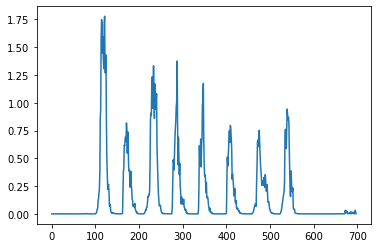

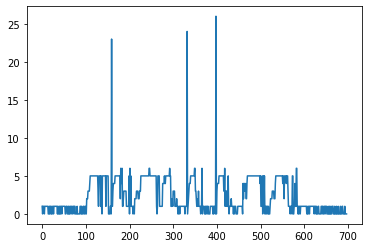

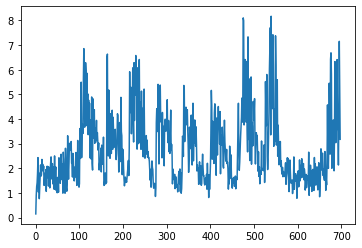

In [414]:
plt.figure()
plt.plot(energy_list)
plt.figure()
plt.plot(frequency_list)
plt.figure()
plt.plot(spectral_flatness_list)


In [415]:
def find_changes(x):
    if x[0]:
        return [0] + [i for i in range(1,len(x)) if x[i]!=x[i-1] ]
    else:
        return [i for i in range(1,len(x)) if x[i]!=x[i-1] ]

delta = find_changes(speech_frames)
delta

[73,
 74,
 101,
 102,
 104,
 105,
 106,
 129,
 130,
 137,
 138,
 146,
 147,
 152,
 155,
 156,
 159,
 160,
 163,
 165,
 167,
 179,
 180,
 184,
 186,
 190,
 192,
 194,
 195,
 198,
 199,
 200,
 201,
 202,
 203,
 204,
 215,
 224,
 225,
 262,
 265,
 269,
 276,
 282,
 283,
 303,
 304,
 305,
 306,
 307,
 308,
 310,
 332,
 333,
 336,
 338,
 339,
 351,
 352,
 354,
 356,
 357,
 360,
 361,
 362,
 363,
 364,
 368,
 398,
 399,
 401,
 404,
 405,
 416,
 417,
 421,
 422,
 423,
 424,
 425,
 426,
 429,
 432,
 433,
 463,
 465,
 469,
 502,
 504,
 506,
 507,
 508,
 509,
 510,
 526,
 530,
 533,
 551,
 552,
 554,
 555,
 559,
 560,
 563,
 573,
 575,
 582,
 584,
 668,
 669,
 672,
 674,
 675,
 678,
 679,
 683,
 684,
 687,
 688,
 693,
 694]

In [416]:
ignore_silent_count = 10
ignore_speech_count = 5

def ignore_too_short(x, start, count, lenght):
    
    i = start
    while i < len(x):
        
        if (i < 0) and (x[0] != 0) and (x[0] < count):
            x.pop(0)
            x.insert(0, 0)
            i += 1
        elif i < 0:
            i += 2
        elif i+1 > len(x) and length-x[i] < count:
            x.pop(i)
        elif i+1 < len(x) and x[i+1]-x[i] < count:
            x.pop(i)
            x.pop(i)
        else:
            i += 2

ignore_too_short(delta, -1, ignore_silent_count, len(speech_frames))
ignore_too_short(delta,  0, ignore_speech_count, len(speech_frames))

delta

[101, 204, 215, 310, 332, 368, 398, 433, 463, 510, 526, 563, 573, 584, 668]

In [417]:
torch.exp(amplitudes.log().mean(-1))

tensor([0.0068])

In [418]:
n = 50
frame = waveform[0, n*frame_size:(n+1)*frame_size].view(1,-1)
frame_fft = torch.rfft(frame, 1)
amplitudes = torchaudio.functional.complex_norm(frame_fft)
spectral_flatness = compute_spectral_flatness(amplitudes)


In [419]:
z = torch.zeros(waveform.shape, dtype=waveform.dtype, device=waveform.device)

import itertools
zipped = itertools.zip_longest(delta[0::2], delta[1::2], fillvalue=-1)

for a,b in zipped:
    z[0, a*frame_size:b*frame_size] = 1.

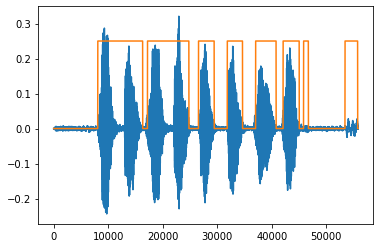

In [420]:
plt.figure()
plt.plot(waveform[0,:].view(1,-1).transpose(0,1).numpy())

# plt.figure()
VISUALIZATION_FACTOR = 0.25
plt.plot(VISUALIZATION_FACTOR*z.t().numpy())

In [421]:
z

tensor([[0., 0., 0.,  ..., 0., 0., 0.]])

In [422]:
amplitudes.size()

torch.Size([1, 41])